# Data Exploration Notebook

## Python Imports

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import contextily as cx
import rtree
from zlib import crc32
import hashlib
from shapely.geometry import Point, LineString, Polygon
import numpy as np
from scipy.spatial import cKDTree
from geopy.distance import distance


## Dependencies 

* Geopandas
* pandas
* openpyxl

## Exploration Plan


### Data Imports 

* /Users/jnapolitano/Projects/wattime-takehome/data/iso_code_conversion.csv: 
* /Users/jnapolitano/Projects/wattime-takehome/data/emissions_csv_fao_emiss_csv_ch4_fao_2015_2019_tonnes.xlsx
* /Users/jnapolitano/Projects/wattime-takehome/data/harvest_2015-2021.xlsx
* /Users/jnapolitano/Projects/wattime-takehome/data/ch4_2015-2021.xlsx  **** unit is g CH4 year according to the paper.  Confirm this unit 

### Extra Data
#### Faostat hectare data
* /Users/jnapolitano/Projects/wattime-takehome/data/FAOSTAT_data_rice_hectares.csv

##### Formated Data written to file
* /Users/jnapolitano/Projects/wattime-takehome/data/FAOSTAT_data_rice_hectares_formatted.csv


### Data Descriptions (source:Data Analysis Take Home Instructions)
* ch4_2015-2021: this is the methane estimates for each of the listed countries for years 2015-2021. 
* harvest_2015-2021: this is the area harvested in each country for each year in hectares. 
* country_shapefiles: this folder contains shapefiles for each country if you wish to use it
* (Emissions_csv_fao_emiss_csv_ch4_fao_2015_2019_tonnes: this is emissions estimates for rice cultivation from FAO Stat. FAO Stat is currently the primary source of agricultural emissions globally. 

### Exploration

* Import each File into a dataframe
* Plot the data
* Calculate descriptive statistics

## ISO CODES



In [180]:
iso_df = pd.read_csv("/Users/jnapolitano/Projects/wattime-takehome/data/iso_code_conversion.csv")

In [181]:
iso_df.head()

,iso3,iso2,country_name
0,ABW,AW,Aruba
1,AFG,AF,Afghanistan
2,AGO,AO,Angola
3,AIA,AI,Anguilla
4,ALA,AX,Åland Islands


## Emissions CSV FAO EMISS CSV CH4 FAO 2015-2019 tonnes Data


### Import to dataframe

In [156]:
filepath = "/Users/jnapolitano/Projects/wattime-takehome/data/emissions_csv_fao_emiss_csv_ch4_fao_2015_2019_tonnes.xlsx"
annual_ch4_tons_df = pd.read_excel(filepath)

### Print Df Head

In [157]:
annual_ch4_tons_df.head()

,code,country,country_fao,2015,2016,2017,2018,2019,2020,2021
0,BGD,Bangladesh,Bangladesh,1131293.4,1093480.4,1154531.0,1144591.0,1144745.4,NaN,NaN
1,BRA,Brazil,Brazil,138910.3,126278.2,130322.9,121615.2,111084.8,NaN,NaN
2,CHN,China,"China, mainland",5406593.9,5399920.0,5400129.0,5302173.1,5214454.7,NaN,NaN
3,ESP,Spain,Spain,55082.2,55073.1,54232.4,52925.0,52098.5,NaN,NaN
4,IDN,Indonesia,Indonesia,2407953.5,2387656.4,2425290.6,2405613.8,2257604.3,NaN,NaN


### Add Units Column for Good Luck


In [158]:
annual_ch4_tons_df['unit'] = "tonnes_CH4"
annual_ch4_tons_df

,code,country,country_fao,2015,2016,2017,2018,2019,2020,2021,unit
0,BGD,Bangladesh,Bangladesh,1131293.4,1093480.4,1154531.0,1144591.0,1144745.4,NaN,NaN,tonnes_CH4
1,BRA,Brazil,Brazil,138910.3,126278.2,130322.9,121615.2,111084.8,NaN,NaN,tonnes_CH4
2,CHN,China,"China, mainland",5406593.9,5399920.0,5400129.0,5302173.1,5214454.7,NaN,NaN,tonnes_CH4
3,ESP,Spain,Spain,55082.2,55073.1,54232.4,52925.0,52098.5,NaN,NaN,tonnes_CH4
4,IDN,Indonesia,Indonesia,2407953.5,2387656.4,2425290.6,2405613.8,2257604.3,NaN,NaN,tonnes_CH4
5,IND,India,India,4580248.4,4559136.4,4620790.8,4661154.9,4621416.8,NaN,NaN,tonnes_CH4
6,IRN,Iran (Islamic Republic of),Iran (Islamic Republic of),116486.7,131008.5,87233.6,93936.6,96103.4,NaN,NaN,tonnes_CH4
7,ITA,Italy,Italy,114574.8,118003.0,118003.0,109463.8,110895.1,NaN,NaN,tonnes_CH4
8,JPN,Japan,Japan,330353.1,326403.0,323700.3,322245.0,320581.8,NaN,NaN,tonnes_CH4
9,KHM,Cambodia,Cambodia,436826.0,459003.1,473745.3,479362.7,468378.9,NaN,NaN,tonnes_CH4


### Annual Tonnes CH4 Line Plot


<AxesSubplot:xlabel='Country Name', ylabel='Tonnes CH4'>

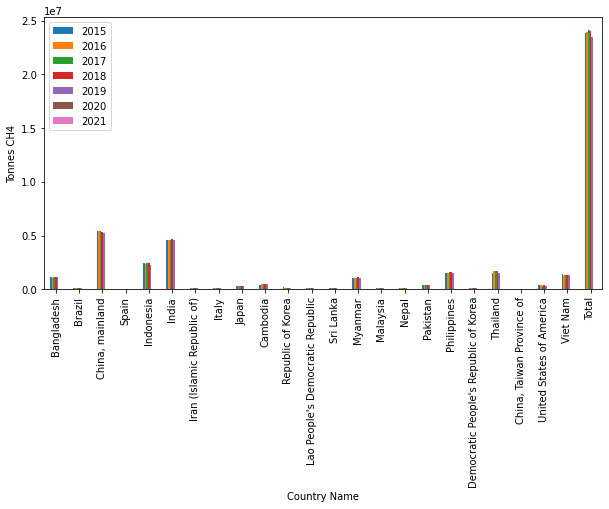

In [159]:
annual_ch4_tons_df.plot(kind = "bar", x = 'country_fao',figsize = (10,5), xlabel = "Country Name", ylabel = "Tonnes CH4",)

### Impressions

The data includes rice produing states. 

## harvest_2015-2021.xlsx Data 

In [160]:
filepath = "/Users/jnapolitano/Projects/wattime-takehome/data/harvest_2015-2021.xlsx"

harvest_2015_2021_df = pd.read_excel(filepath)

### Print Df Head

In [161]:
harvest_2015_2021_df.head()

,iso3_country,country_name,harvest_ha_2015,harvest_ha_2016,harvest_ha_2017,harvest_ha_2018,harvest_ha_2019,harvest_ha_2020,harvest_ha_2021
0,BGD,Bangladesh,11722099,11390790,10494788,10706153,10354925,10533907,9919869
1,BRA,Brazil,1705117,1552095,1862587,1858515,1647357,2451437,2272437
2,CHN,China,30668234,29297656,31775354,27069813,28016761,32011764,30341048
3,ESP,Spain,57073,66740,60865,70270,57416,65273,42658
4,IDN,Indonesia,6418245,5115649,4807663,5884907,6333339,5940978,5049681


### Harvest 2015 - 2021 Bar Plot

<AxesSubplot:xlabel='Country Name', ylabel='Hectares Harvested'>

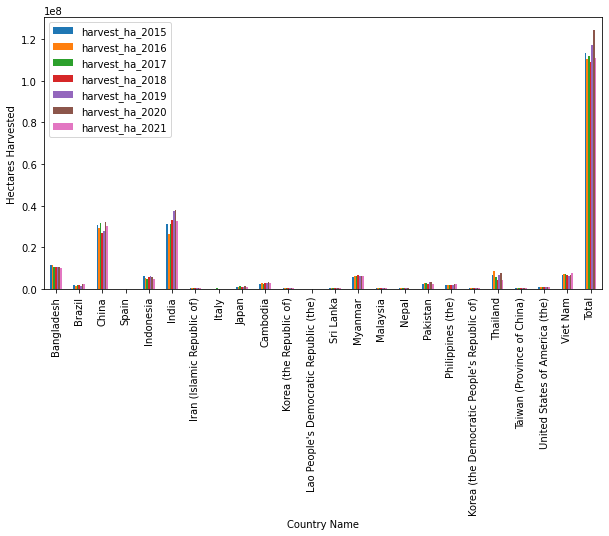

In [162]:
harvest_2015_2021_df.plot(kind = "bar", x = 'country_name', xlabel = "Country Name", ylabel = "Hectares Harvested", figsize = (10,5))

## CH4_2015-2021 Data

### Import to dataframe

In [163]:
filepath = "/Users/jnapolitano/Projects/wattime-takehome/data/ch4_2015-2021.xlsx"
annual_ch4_df = pd.read_excel(filepath)

### Print Df Head

In [164]:
annual_ch4_df.head()

,iso3_country,country_name,tCH4_2015,tCH4_2016,tCH4_2017,tCH4_2018,tCH4_2019,tCH4_2020,tCH4_2021
0,BGD,Bangladesh,2.344420e+06,2.278158e+06,2.098958e+06,2.141231e+06,2.070985e+06,2.106781e+06,1.983974e+06
1,BRA,Brazil,3.410233e+05,3.104189e+05,3.725173e+05,3.717030e+05,3.294713e+05,4.902874e+05,4.544874e+05
2,CHN,China,6.133647e+06,5.859531e+06,6.355071e+06,5.413962e+06,5.603352e+06,6.402353e+06,6.068210e+06
3,ESP,Spain,1.141464e+04,1.334803e+04,1.217299e+04,1.405410e+04,1.148324e+04,1.305461e+04,8.531579e+03
4,IDN,Indonesia,1.283649e+06,1.023129e+06,9.615327e+05,1.176982e+06,1.266668e+06,1.188195e+06,1.009936e+06


####  Note

```{note}
The Data differs from the ch4_tonnes_data_frame. Review to be sure unites are equivalent
```

### CH4 2015 - 2021 Bar Plot

<AxesSubplot:ylabel='Country Name'>

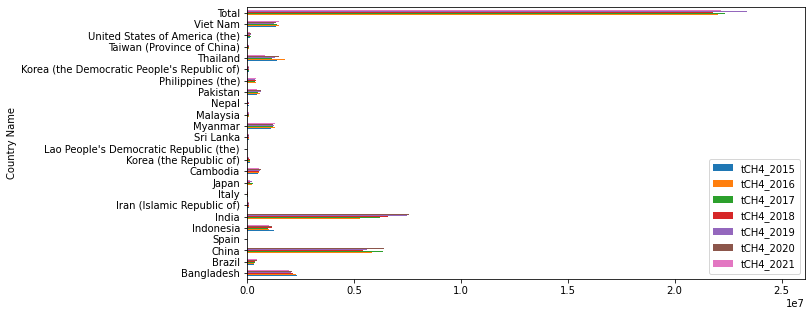

In [165]:
annual_ch4_df.plot(kind = "barh", x = 'country_name', xlabel = "Country Name", ylabel = "Tonnes Ch4", figsize = (10,5))

## FaoStat Hectare Data
This data was downloaded from the faostat website. 

### Import Data from File

In [298]:
filepath = "/Users/jnapolitano/Projects/wattime-takehome/data/FAOSTAT_data_rice_hectares.csv"
faostat_hectares_df = pd.read_csv(filepath)

In [299]:
faostat_hectares_df

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,16,Bangladesh,5312,Area harvested,27,"Rice, paddy",2015,2015,ha,11381221,NaN,Official data
1,QCL,Crops and livestock products,16,Bangladesh,5312,Area harvested,27,"Rice, paddy",2016,2016,ha,11000809,NaN,Official data
2,QCL,Crops and livestock products,16,Bangladesh,5312,Area harvested,27,"Rice, paddy",2017,2017,ha,11615000,NaN,Official data
3,QCL,Crops and livestock products,16,Bangladesh,5312,Area harvested,27,"Rice, paddy",2018,2018,ha,11515000,NaN,Official data
4,QCL,Crops and livestock products,16,Bangladesh,5312,Area harvested,27,"Rice, paddy",2019,2019,ha,11515545,NaN,Official data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,QCL,Crops and livestock products,237,Viet Nam,5312,Area harvested,27,"Rice, paddy",2016,2016,ha,7734722,NaN,Official data
128,QCL,Crops and livestock products,237,Viet Nam,5312,Area harvested,27,"Rice, paddy",2017,2017,ha,7708534,NaN,Official data
129,QCL,Crops and livestock products,237,Viet Nam,5312,Area harvested,27,"Rice, paddy",2018,2018,ha,7570741,NaN,Official data
130,QCL,Crops and livestock products,237,Viet Nam,5312,Area harvested,27,"Rice, paddy",2019,2019,ha,7451544,NaN,Official data


### Clean Up Data for Analysis

#### Drop Unnecessary Columns

In [300]:
drop_columns = ['Item Code (FAO)',  'Area Code (FAO)','Element','Element Code','Domain', 'Domain Code', 'Item', 'Unit', 'Flag', 'Flag Description', 'Year Code']
faostat_hectares_df.drop(labels= drop_columns ,axis = 1, inplace = True)

### Area to country_name

In [301]:
faostat_hectares_df.rename(columns={"Area": "country_name"}, inplace =True)

In [302]:
faostat_hectares_df

,country_name,Year,Value
0,Bangladesh,2015,11381221
1,Bangladesh,2016,11000809
2,Bangladesh,2017,11615000
3,Bangladesh,2018,11515000
4,Bangladesh,2019,11515545
...,...,...,...
127,Viet Nam,2016,7734722
128,Viet Nam,2017,7708534
129,Viet Nam,2018,7570741
130,Viet Nam,2019,7451544


### Conver numeric to strings for merge

In [303]:
#faostat_hectares_df = faostat_hectares_df.astype(str)

In [304]:
faostat_hectares_df.rename(columns={"iso3": "iso3_country"}, inplace =True)

#### Pivot Dataframe

In [305]:
faostat_hectares_df = faostat_hectares_df.pivot(index=['country_name'], columns=['Year'])

In [306]:
faostat_hectares_df

Value                                \
Year                                  2015      2016      2017      2018   
country_name                                                               
Bangladesh                        11381221  11000809  11615000  11515000   
Brazil                             2138397   1943938   2006202   1872155   
Cambodia                           2799126   2889449   2972213   3036117   
China, Taiwan Province of           251861    273837    274677    271506   
China, mainland                   30784000  30746000  30747190  30189450   
India                             43390000  43190000  43774070  44156450   
Indonesia                         11389000  10600000  10900000  11377934   
Iran (Islamic Republic of)          529967    596035    396877    427373   
Italy                               227331    234133    234133    217190   
Japan                              1589000   1570000   1557000   1470000   
Lao People's Democratic Republic    965152    973327    956134    848174   
Malaysia                            681559    688770    685548    699980   
Myanmar                            6769494   6723986   6945982   7149311   
Nepal                              1425346   1362908   1552469   1469545   
Pakistan                           2739495   2724013   2900595   2810030   
Philippines                        4656227   4556043   4811808   4800406   
Republic of Korea                   799344    778734    754713    737673   
Spain                               109290    109272    107604    105010   
Sri Lanka                          1243345   1141323    791679   1040954   
Thailand                           9717975  10734279  10719698  10647941   
United States of America           1042080   1253320    960730   1177650   
Viet Nam                           7828607   7734722   7708534   7570741   

                                                      
Year                                  2019      2020  
country_name                                          
Bangladesh                        11515545  11417745  
Brazil                             1710063   1677705  
Cambodia                           2964493   2917391  
China, Taiwan Province of           270066    261784  
China, mainland                   29690000  30080000  
India                             43780000  45000000  
Indonesia                         10677887  10657275  
Iran (Islamic Republic of)          420349    422746  
Italy                               220030    227320  
Japan                              1470000   1462000  
Lao People's Democratic Republic    807239    821188  
Malaysia                            672084    645511  
Myanmar                            6920875   6655811  
Nepal                              1491744   1458915  
Pakistan                           3033909   3335105  
Philippines                        4651490   4718896  
Republic of Korea                   729814    726432  
Spain                               103370    102060  
Sri Lanka                           957596   1066403  
Thailand                           9812614  10401653  
United States of America           1002420   1208810  
Viet Nam                           7451544   7222618

#### Convert DF to the same format as the other data tables

In [307]:
faostat_hectares_df.columns = faostat_hectares_df.columns.droplevel(0) #remove amount
faostat_hectares_df.columns.name = None               #remove categories
faostat_hectares_df = faostat_hectares_df.reset_index()                #index to columns

In [308]:
faostat_hectares_df

,country_name,2015,2016,2017,2018,2019,2020
0,Bangladesh,11381221,11000809,11615000,11515000,11515545,11417745
1,Brazil,2138397,1943938,2006202,1872155,1710063,1677705
2,Cambodia,2799126,2889449,2972213,3036117,2964493,2917391
3,"China, Taiwan Province of",251861,273837,274677,271506,270066,261784
4,"China, mainland",30784000,30746000,30747190,30189450,29690000,30080000
5,India,43390000,43190000,43774070,44156450,43780000,45000000
6,Indonesia,11389000,10600000,10900000,11377934,10677887,10657275
7,Iran (Islamic Republic of),529967,596035,396877,427373,420349,422746
8,Italy,227331,234133,234133,217190,220030,227320
9,Japan,1589000,1570000,1557000,1470000,1470000,1462000


#### Calculate Totals

In [309]:
faostat_hectares_df.loc['total'] = faostat_hectares_df.select_dtypes(np.number).sum()

In [310]:
faostat_hectares_df

,country_name,2015,2016,2017,2018,2019,2020
0,Bangladesh,11381221.0,11000809.0,11615000.0,11515000.0,11515545.0,11417745.0
1,Brazil,2138397.0,1943938.0,2006202.0,1872155.0,1710063.0,1677705.0
2,Cambodia,2799126.0,2889449.0,2972213.0,3036117.0,2964493.0,2917391.0
3,"China, Taiwan Province of",251861.0,273837.0,274677.0,271506.0,270066.0,261784.0
4,"China, mainland",30784000.0,30746000.0,30747190.0,30189450.0,29690000.0,30080000.0
5,India,43390000.0,43190000.0,43774070.0,44156450.0,43780000.0,45000000.0
6,Indonesia,11389000.0,10600000.0,10900000.0,11377934.0,10677887.0,10657275.0
7,Iran (Islamic Republic of),529967.0,596035.0,396877.0,427373.0,420349.0,422746.0
8,Italy,227331.0,234133.0,234133.0,217190.0,220030.0,227320.0
9,Japan,1589000.0,1570000.0,1557000.0,1470000.0,1470000.0,1462000.0


#### Reset Index and Change Area Code to NAN

In [311]:

faostat_hectares_df.at['total','country_name'] = 'Total'
#faostat_hectares_df.at['total','country_name'] = np.nan

faostat_hectares_df.reset_index(inplace=True, drop=True)


In [312]:
faostat_hectares_df

,country_name,2015,2016,2017,2018,2019,2020
0,Bangladesh,11381221.0,11000809.0,11615000.0,11515000.0,11515545.0,11417745.0
1,Brazil,2138397.0,1943938.0,2006202.0,1872155.0,1710063.0,1677705.0
2,Cambodia,2799126.0,2889449.0,2972213.0,3036117.0,2964493.0,2917391.0
3,"China, Taiwan Province of",251861.0,273837.0,274677.0,271506.0,270066.0,261784.0
4,"China, mainland",30784000.0,30746000.0,30747190.0,30189450.0,29690000.0,30080000.0
5,India,43390000.0,43190000.0,43774070.0,44156450.0,43780000.0,45000000.0
6,Indonesia,11389000.0,10600000.0,10900000.0,11377934.0,10677887.0,10657275.0
7,Iran (Islamic Republic of),529967.0,596035.0,396877.0,427373.0,420349.0,422746.0
8,Italy,227331.0,234133.0,234133.0,217190.0,220030.0,227320.0
9,Japan,1589000.0,1570000.0,1557000.0,1470000.0,1470000.0,1462000.0


#### Write Dataframe to file 

In [313]:
outpath = "/Users/jnapolitano/Projects/wattime-takehome/data/FAOSTAT_data_rice_hectares_formatted.csv"
faostat_hectares_df.to_csv(outpath)

### Plotting the FAOSTAT Hectare Data

<AxesSubplot:ylabel='Country Name'>

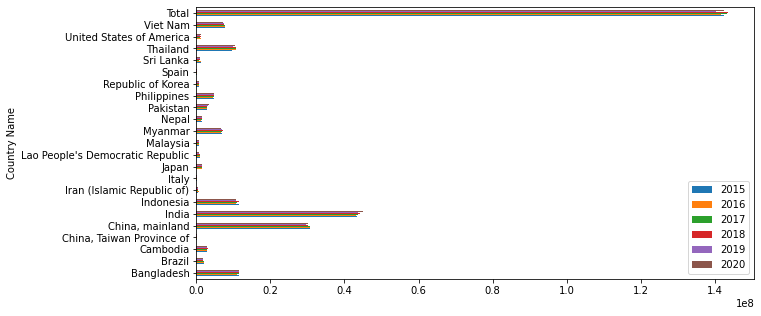

In [315]:
## The Dataframe is Currently cached there is no need to read it from file. 
faostat_hectares_df.plot(kind = "barh", x = 'country_name', xlabel = "Country Name", ylabel = "Hectares Harvested", figsize = (10,5))

## Impressions thus Far

### Relative Difference Between the FAO Stat data and the PaddyWatch/Malaysian Data

I noticed a differnce in the estimates between the two emission estimate sources.  I initially thought that the sources were reporting in different units, but in reading the attached paper from University of Malaysia I found that the paddy watch( university of malaysia uses a larger emission factor than faostat)

#### Source
"The larger value is due to the larger emission factor used by Paddy Watch." *** Create a footnote with this.  Page5 of document.


#### What is the story? 

##### Walk through the data.
* Show and explain what is contained within the files

    * Print the Dataframes.
        * Actually exclude this from the blog post.  I am limited to 300-500 words.  A full report can be completed later. 

    * Plot bar, scatter, etc
        * Experiment with the plots to identify those that tell the best stories. 


    
* Discuss differences between the estimates

    * Calculate relative differences in hectares

    * Calculate relative difference in emissions

* What Accounts for the differences

* Which data should be used to estimate emissions

* Discuss the Co2equivalency and discuss whether we should include methane emissions in the reports.  

* Argue for a reduction in emissions to align with mission statement.  


### Next Steps
 
* Compare Hectare Data
* Compare Emission Data
* Convert ch4 to co2 equivalencies
* model the difference between the two sets and the impact on overall emission projections in 2020
* Plot chloropleth of States to emission levels
* Plot Chloropeth of states to hecatares ares. 
* Plot Cloropleth of differences

